In [2]:
import sys
import os
import torch

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='1'

import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import torch.nn.functional as F

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from equivariant_pose_graph.utils.color_utils import color_gradient

from pytorch3d.transforms import Transform3d, Rotate, Translate

from torch.utils.data import DataLoader

from equivariant_pose_graph.utils.se3 import random_se3
from pytorch3d.transforms import Transform3d
from pytorch_lightning.utilities.seed import seed_everything

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def toDisplay(x, target_dim = None):
    while(target_dim is not None and x.dim() > target_dim):
        x = x[0]
    return x.detach().cpu().numpy()

In [4]:
from pytorch3d.transforms import Transform3d,Rotate, rotation_6d_to_matrix, se3_exp_map
from equivariant_pose_graph.utils.se3 import *
from equivariant_pose_graph.utils.display import *
from equivariant_pose_graph.dataset.point_cloud_dataset import PointCloudDataset
from equivariant_pose_graph.dataset.point_cloud_data_module import MultiviewDataModule

In [5]:
from hydra import compose, initialize
from omegaconf import OmegaConf

initialize(config_path="../../taxpose/configs/model", job_name="taxposed")

/tmp/ipykernel_3996093/19244753.py:4: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="../../taxpose/configs/model", job_name="taxposed")


hydra.initialize()

In [15]:
from equivariant_pose_graph.models.transformer_flow import ResidualFlow_DiffEmbTransformer
from equivariant_pose_graph.models.multimodal_transformer_flow import Multimodal_ResidualFlow_DiffEmbTransformer, Multimodal_ResidualFlow_DiffEmbTransformer_WithPZCondX
from equivariant_pose_graph.training.flow_equivariance_training_module_nocentering_eval_init import EquivarianceTestingModule
from equivariant_pose_graph.training.flow_equivariance_training_module_nocentering_multimodal import EquivarianceTrainingModule, EquivarianceTrainingModule_WithPZCondX

# place_checkpoint_file='/home/chuerp/good_mug_models/rm/epoch=120-step=15125.ckpt'
# place_network = ResidualFlow_DiffEmbTransformer(
#                     emb_nn='dgcnn', return_flow_component=True, center_feature=True,
#                     inital_sampling_ratio=1)
# place_model = EquivarianceTestingModule(
#     place_network,
#     lr=1e-4,
#     image_log_period=100,
#     weight_normalize='l1',
#     loop=1
# )

# noreg
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2022-11-21_154442/residual_flow_occlusion/2fk29m3e/checkpoints/epoch_27_global_step_7000.ckpt"
# noreg continued
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2022-12-01_025300/residual_flow_occlusion/1db7s7cq/checkpoints/epoch=125-step=31500.ckpt"
# uniform reg
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2022-11-30_155029/residual_flow_occlusion/17bt6tod/checkpoints/epoch_43_global_step_11000.ckpt"
# noreg overall mean center
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2022-12-01_025300/residual_flow_occlusion/1db7s7cq/checkpoints/epoch_123_global_step_31000.ckpt"
# noreg overall mean center. exp dense point cloud
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2022-12-01_234630/residual_flow_occlusion/2ghi50y6/checkpoints/epoch_103_global_step_26000.ckpt"
# L2 norm conditioning
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2022-12-20_175830/residual_flow_occlusion/3ppf0g8p/checkpoints/epoch_111_global_step_28000.ckpt"
# ^ l2 norm conditiong but With p(z|X)
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2022-12-22_002311/residual_flow_occlusion/15zfvyx1/checkpoints/epoch_75_global_step_19000.ckpt"
# ^ but overfit on the overfit train dataset
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2022-12-23_014459/residual_flow_occlusion/1e4vc8gx/checkpoints/epoch_35_global_step_9000.ckpt"
# ^ but the loss is only the p(z|X) loss, so it acutally optimizes
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-01-04_235552/residual_flow_occlusion/wcshkbzy/checkpoints/epoch_35_global_step_9000.ckpt"
# [overfit dataset] low lr and has bad kl loss. however, this looks like it has a better latent p(z|X)?
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-01-04_121156/residual_flow_occlusion/10mhwx6g/checkpoints/epoch_199_global_step_50000.ckpt"
# mse loss?
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-01-05_003452/residual_flow_occlusion/qhfhic8n/checkpoints/epoch_7_global_step_2000.ckpt"
# mse loss with only one dgcnn (no anchor/action separation)
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-01-05_010323/residual_flow_occlusion/3dhhdrih/checkpoints/epoch_11_global_step_3000.ckpt"
# mse loss trained on 2 mugs in the train dataset
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-01-05_223316/residual_flow_occlusion/2vwec0gm/checkpoints/epoch_35_global_step_9000.ckpt"
# mse loss trained on 3 mugs
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-01-05_231713/residual_flow_occlusion/103sexr1/checkpoints/epoch_39_global_step_10000.ckpt"
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-01-06_000501/residual_flow_occlusion/sp1sof97/checkpoints/epoch_75_global_step_19000.ckpt"
# inverse kl + all mugs
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-01-06_090446/residual_flow_occlusion/1hjwr3f8/checkpoints/epoch_15_global_step_4000.ckpt"
# forward kl + mse + all mugs
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-01-06_090351/residual_flow_occlusion/uqaun9iz/checkpoints/epoch_15_global_step_4000.ckpt"
# normed inverse kl + all mugs + 2 DGCNN
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-01-09_162211/residual_flow_occlusion/2i7yifsv/checkpoints/epoch_143_global_step_36000.ckpt"
# normed inverse kl + all mugs + 1 DGCNN not 2
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-01-10_000911/residual_flow_occlusion/1ds271fl/checkpoints/epoch_159_global_step_40000.ckpt"
# normed forward kl + all mugs + 1 DGCNN not 2
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-01-10_195720/residual_flow_occlusion/z922svt3/checkpoints/epoch_23_global_step_6000.ckpt"
# forward kl + starting from pretrained inverse kl
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-01-11_165435/residual_flow_occlusion/5kdqbhid/checkpoints/epoch_99_global_step_25000.ckpt"
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-01-11_165435/residual_flow_occlusion/5kdqbhid/checkpoints/epoch_11_global_step_3000.ckpt"
# 
# inverse kl but 2D probabilities for the 2 objects
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-01-12_122937/residual_flow_occlusion/22dsk7ml/checkpoints/epoch_71_global_step_18000.ckpt"

# inverse kl but with kl(mug) + kl(rack) loss
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-01-12_001023/residual_flow_occlusion/3czoym0x/checkpoints/epoch_95_global_step_24000.ckpt"

# mug only inverse kl
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-01-12_130619/residual_flow_occlusion/1mmwz1ae/checkpoints/epoch_31_global_step_8000.ckpt"


# 1 DGCNN
# 1 mug overfit inverse kl
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-01-12_150034/residual_flow_occlusion/3k1e3uq6/checkpoints/epoch_11_global_step_3000.ckpt"
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-01-12_152242/residual_flow_occlusion/3pgp6833/checkpoints/epoch_3_global_step_1000.ckpt"
# 2 mug overfit inverse kl
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-01-12_155828/residual_flow_occlusion/2nswo2uu/checkpoints/epoch_35_global_step_9000.ckpt"
# 3 mug overfit inverse kl
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-01-12_155847/residual_flow_occlusion/1rbhvbfr/checkpoints/epoch_11_global_step_3000.ckpt"
# all mugs

# 2 DGCNN
# 1 mug overfit inverse kl
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-01-17_145122/residual_flow_occlusion/23n57sp0/checkpoints/epoch_31_global_step_8000.ckpt"
# 2 mug overfit inverse kl
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-01-13_140201/residual_flow_occlusion/2ofq050u/checkpoints/epoch_31_global_step_8000.ckpt"
# 3 mug overfit inverse kl
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-01-17_154329/residual_flow_occlusion/3cejcxfp/checkpoints/epoch_35_global_step_9000.ckpt"

# prev thing
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-01-20_002146/residual_flow_occlusion/2ajhzffe/checkpoints/epoch_19_global_step_5000.ckpt"
# new thing!!11!!
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-01-24_122703/residual_flow_occlusion/1xjwly3u/checkpoints/epoch_55_global_step_14000.ckpt"

# frozen p(z|Y) training midway
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-01-24_122703/residual_flow_occlusion/1xjwly3u/checkpoints/epoch_679_global_step_170000.ckpt"
# joint training midway
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-01-24_160629/residual_flow_occlusion/hsiytsno/checkpoints/epoch_575_global_step_144000.ckpt"

# frozen p(z|Y) then joint training
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-01-25_210745/residual_flow_occlusion/3657upcl/checkpoints/epoch_419_global_step_105000.ckpt"

# test
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-01-17_165433/residual_flow_occlusion/1xwalcte/checkpoints/epoch_7_global_step_2000.ckpt"
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-01-17_165433/residual_flow_occlusion/1xwalcte/checkpoints/epoch_3_global_step_1000.ckpt"
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-01-17_173655/residual_flow_occlusion/3b2lyamk/checkpoints/epoch_3_global_step_1000.ckpt"

# inner_network = ResidualFlow_DiffEmbTransformer(
#                     emb_nn='dgcnn', return_flow_component=True, center_feature=True,
#                     inital_sampling_ratio=1, input_dims=4)
# place_network = Multimodal_ResidualFlow_DiffEmbTransformer(
#                     inner_network, gumbel_temp=0.5, center_feature=True)
# place_model = EquivarianceTrainingModule(
#     place_network,
#     lr=1e-4,
#     image_log_period=100,
#     weight_normalize='softmax', #'l1',
#     softmax_temperature=1
# )

# goal emb before joint train
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-01-24_122703/residual_flow_occlusion/1xjwly3u/checkpoints/epoch_887_global_step_222000.ckpt"
# goal emb then joint train
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-01-27_114929/residual_flow_occlusion/3qas7l61/checkpoints/epoch_199_global_step_50000.ckpt"

# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-02-02_141024/residual_flow_occlusion/16z6nj54/checkpoints/epoch_11_global_step_3000.ckpt"


# add smooth
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-03-09_010827/residual_flow_occlusion/2r9q5ig3/checkpoints/epoch_427_global_step_107000.ckpt"

# division smooth
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-03-09_010903/residual_flow_occlusion/26up1fdq/checkpoints/epoch_999_global_step_250000.ckpt"

# 2 rack overfit
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-03-15_145531/residual_flow_occlusion/26qo410g/checkpoints/epoch_3_global_step_1000.ckpt"

# 1 rack overfit
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-03-15_155047/residual_flow_occlusion/37cs1pnj/checkpoints/epoch_3_global_step_1000.ckpt"


# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-04-08_105032/residual_flow_occlusion/zwg4mxwt/checkpoints/epoch_799_global_step_200000.ckpt"

# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/data/merged_3_step_train_earlierckpt.ckpt"

# inner_network = ResidualFlow_DiffEmbTransformer(
#                     emb_nn='dgcnn', return_flow_component=True, center_feature=True,
#                     inital_sampling_ratio=1, input_dims=4)
# place_nocond_network = Multimodal_ResidualFlow_DiffEmbTransformer(
#                     inner_network, gumbel_temp=0.5, center_feature=True, division_smooth_factor=1, add_smooth_factor=0.05)
# place_network = Multimodal_ResidualFlow_DiffEmbTransformer_WithPZCondX(
#                     place_nocond_network, encoder_type="2_dgcnn")
# place_nocond_model = EquivarianceTrainingModule(
#     place_nocond_network,
#     lr=1e-4,
#     image_log_period=100,
#     weight_normalize='softmax', #'l1',
#     softmax_temperature=1
# )
# place_model = EquivarianceTrainingModule_WithPZCondX(
#     place_network,
#     place_nocond_model,
# )


# place_model.cuda()
# place_model.load_state_dict(torch.load(place_checkpoint_file)['state_dict']);

from equivariant_pose_graph.utils.load_model_utils import load_merged_model

cfg = compose(config_name="taxposed-2rackaugfinal", overrides=[])
# print(OmegaConf.to_yaml(cfg))



# # pzY_fn = "/home/jenny/data/equivariant_pose_graph/logs/residual_flow_occlusion/2023-07-14_172728/residual_flow_occlusion/uo5zi7t8/checkpoints/epoch_2603_global_step_164000.ckpt"
# # pzX_fn = "/home/jenny/data/equivariant_pose_graph/logs/residual_flow_occlusion/2023-07-19_093436/residual_flow_occlusion/fp0ucvji/checkpoints/epoch_1428_global_step_90000.ckpt"

# task = "bottle_place"
# pzY_fn = "/home/jenny/data/equivariant_pose_graph/logs/residual_flow_occlusion/2023-09-07_010525/residual_flow_occlusion/psidhats/checkpoints/epoch_399_global_step_50000.ckpt"
# pzX_fn = "/home/jenny/data/equivariant_pose_graph/logs/residual_flow_occlusion/2023-09-08_145701/residual_flow_occlusion/ze8ct05i/checkpoints/epoch_1599_global_step_200000.ckpt"

# task = "mug_2rackauginf_place"
task = "mug_2rackfixed_place"
pzY_fn = "/home/jenny/data/equivariant_pose_graph/logs/residual_flow_occlusion/2023-08-25_164441/residual_flow_occlusion/wia2jdcr/checkpoints/epoch_999_global_step_125000.ckpt"
pzX_fn = "/home/jenny/data/equivariant_pose_graph/logs/residual_flow_occlusion/2023-08-29_224412/residual_flow_occlusion/z8cgqhkg/checkpoints/epoch_1599_global_step_200000.ckpt"

place_model = load_merged_model(pzY_fn, pzX_fn, return_flow_component=True, cfg=cfg)




/home/jenny/.local/lib/python3.9/site-packages/hydra/_internal/defaults_list.py:251: UserWarning:

In 'taxposed-2rackaugfinal': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information



Loading model with architecture specified in configs
Loading model with architecture specified in configs


In [16]:
[print(f"{k}: {v}") for k, v in cfg.items()]

name: taxposed_2rackaugfinal
pred_weight: True
emb_nn: dgcnn
emb_dims: 512
return_flow_component: False
center_feature: True
inital_sampling_ratio: 1
residual_on: True
multilaterate: False
mlat_sample: None
mlat_nkps: None
num_points: 1024
break_symmetry: True
num_workers: 10
batch_size: 8
num_demo: 24
dataset_index: None
object_type: mug
action: place
dataset_size: 1000
rotation_variance: 180
translation_variance: 0.5
plane_occlusion: True
ball_occlusion: True
gripper_lr_label: False
occlusion_class: 0
overfit: False
num_overfit_transforms: 1
seed_overfit_transforms: True
set_Y_transform_to_identity: True
set_Y_transform_to_overfit: True
seed: 0
demo_mod_k_range_min: 2
demo_mod_k_range_max: 2
demo_mod_rot_var: 360
demo_mod_trans_var: 0.15
ckpt_save_freq: 5000
multimodal_transform_base: False
diff_emb: True
diff_transformer: True
latent_z_linear_size: 40
flow_compute_type: 0
weight_normalize: softmax
sigmoid_on: True
softmax_temperature: 1
mlp: False
gumbel_temp: 1
division_smooth_fact

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [17]:
# from torch.utils.data import DataLoader

# def vis(base_mug_id, add_smooth=0, division_smooth=1):
#     np.set_printoptions(precision=2)
#     vis_train = True
#     fig2 = go.FigureWidget(
#         make_subplots(
#                 column_widths=[1],
#                 row_heights=[1, 1, 1],
#                 rows=3, cols=1,
#                 specs=[[{'type': 'surface'}], [{'type': 'surface'}], [{'type': 'surface'}]],
#                 subplot_titles=([f"Mug #999{base_mug_id}'s p(z)" if not vis_train else f"Mug #999{base_mug_id}'s p(z|Y)",
#                                 f"Mug #{base_mug_id}'s p(z)" if not vis_train else f"Mug #{base_mug_id}'s p(z|Y)",
#                                 f"Mug #{base_mug_id}'s p(z|X)",
#                                 ])
#         )
#     )
    
#     fig2.update_layout(
#         height=800,
#     )
    
#     mug_dm = MultiviewDataModule(
#         dataset_root="/home/jenny/data/taxpose/data/mug_grasp/train_data/renders",
#         test_dataset_root="/home/jenny/data/taxpose/data/mug_grasp/test_data/renders",
#         dataset_index=[f"{base_mug_id}"],
#         action_class=2,
#         anchor_class=0,
#         dataset_size=1000,
#         rotation_variance=np.pi/180 * 180,
#         translation_variance=0.5,
#         batch_size=1,
#         num_workers=1,
#         cloud_type="pre_grasp",
#         num_points=1024,
#         overfit=True,
#         num_overfit_transforms=1,
#         seed_overfit_transforms=True,
#         set_Y_transform_to_identity=True,
#         synthetic_occlusion=False,
#         ball_radius=0.1
#     )
#     mug_dm.setup()
    
#     mug_id = base_mug_id
#     dataloader = mug_dm.train_dataloader()
#     i = 0
#     for data in dataloader:
#         points_action = data['points_action'].cuda()#[:,:-2]
#         points_anchor = data['points_anchor'].cuda()

#         points_action_trans = data['points_action_trans'].cuda()
#         points_anchor_trans = data['points_anchor_trans'].cuda()

#         points_action_onetrans = data['points_action_onetrans'].cuda()
#         points_anchor_onetrans = data['points_anchor_onetrans'].cuda()

#         T0 = Transform3d(matrix=data['T0'].cuda())
#         T1 = Transform3d(matrix=data['T1'].cuda())

#         break


#     action_pts = toDisplay(points_action)[0]
#     anchor_pts = toDisplay(points_anchor)[0]
#     action_trans_pts = toDisplay(points_action_trans)[0]
#     anchor_trans_pts = toDisplay(points_anchor_trans)[0]

#     ######

#     action_pts_self_dmean = action_pts-action_pts.mean(axis=0)
#     anchor_pts_self_dmean = anchor_pts-anchor_pts.mean(axis=0)

#     action_pts_dmean = action_pts - np.concatenate([action_pts, anchor_pts], axis=0).mean(axis=0)
#     fig2.add_trace(
#         go.Scatter3d(
#             x = action_pts_dmean[:,0], 
#             y = action_pts_dmean[:,1], 
#             z = action_pts_dmean[:,2], 
#             mode = 'markers',
#             hoverinfo = 'none',
#             name='a',
#         ), 
#         row=1, col=1
#     )


#     anchor_pts_dmean = anchor_pts - np.concatenate([action_pts, anchor_pts], axis=0).mean(axis=0)
#     fig2.add_trace(
#         go.Scatter3d(
#             x = anchor_pts_dmean[:,0], 
#             y = anchor_pts_dmean[:,1], 
#             z = anchor_pts_dmean[:,2], 
#             mode = 'markers',
#             hoverinfo = 'none',
#             name='a',
#         ), 
#         row=2, col=1
#     )


#     fig2.add_trace(
#         go.Scatter3d(
#             x = action_pts_dmean[:,0], 
#             y = action_pts_dmean[:,1], 
#             z = action_pts_dmean[:,2], 
#             mode = 'markers',
#             hoverinfo = 'none',
#             name='a',
#         ), 
#         row=3, col=1
#     )
    

#     fig2.add_trace(
#         go.Scatter3d(
#             x = anchor_pts_dmean[:,0], 
#             y = anchor_pts_dmean[:,1], 
#             z = anchor_pts_dmean[:,2], 
#             mode = 'markers',
#             hoverinfo = 'none',
#             name='a',
#         ), 
#         row=3, col=1
#     )
#     return fig2
# vis(0)


In [18]:
# from torch.utils.data import DataLoader

# def vis(base_mug_id, add_smooth=0.05, division_smooth=1, task="mug_1rack_place"):
#     task2configs = {
#         "mug_1rack_place": {
#             "dataset_root": "/home/jenny/data/taxpose/data/mug_grasp/train_data/renders",
#             "test_dataset_root": "/home/jenny/data/taxpose/data/mug_grasp/test_data/renders",
#             "action_class": 0,
#             "anchor_class": 1,
#             "distractor_anchor_aug": False,
#             "cloud_type": "teleport",
#         },
#         "mug_grasp": {
#             "dataset_root": "/home/jenny/data/taxpose/data/mug_grasp/train_data/renders",
#             "test_dataset_root": "/home/jenny/data/taxpose/data/mug_grasp/test_data/renders",
#             "action_class": 2,
#             "anchor_class": 0,
#             "distractor_anchor_aug": False,
#             "cloud_type": "pre_grasp",
#         },
#         "mug_2rackfixed_place": {
#             "dataset_root": "/home/jenny/code/equivariant_pose_graph/data/train_data_duprack_bothmugrack/renders",
#             "test_dataset_root": "/home/jenny/code/equivariant_pose_graph/data/test_data_duprack_bothmugrack/renders",
#             "action_class": 0,
#             "anchor_class": 1,
#             "distractor_anchor_aug": False,
#             "cloud_type": "teleport",
#         },
#         "mug_2rackauginf_place": {
#             "dataset_root": "/home/jenny/code/equivariant_pose_graph/data/train_data/renders",
#             "test_dataset_root": "/home/jenny/code/equivariant_pose_graph/data/test_data/renders",
#             "action_class": 0,
#             "anchor_class": 1,
#             "distractor_anchor_aug": True,
#             "cloud_type": "teleport",
#         },
#         "bottle_place": {
#             "dataset_root": "/home/jenny/code/equivariant_pose_graph/data/bottle_place/bottle_train_data_ndf_cons_3/renders",
#             "test_dataset_root": "/home/jenny/code/equivariant_pose_graph/data/bottle_place/bottle_train_data_ndf_cons_3/renders",
#             # "test_dataset_root": "/home/jenny/code/equivariant_pose_graph/data/bottle_place/bottle_test_new_3/renders",
            
#             "action_class": 0,
#             "anchor_class": 1,
#             "distractor_anchor_aug": False,
#             "cloud_type": "teleport",
#         },
#         "bottle_grasp": {
#             "dataset_root": "/home/jenny/code/equivariant_pose_graph/data/bottle_place/bottle_train_data_ndf_cons_3/renders",
#             "test_dataset_root": "/home/jenny/code/equivariant_pose_graph/data/bottle_place/bottle_test_new_3/renders",
#             "action_class": 2,
#             "anchor_class": 0,
#             "distractor_anchor_aug": False,
#             "cloud_type": "pre_grasp",
#         },
#          "bowl_place": {
#             "dataset_root": "/home/jenny/code/equivariant_pose_graph/data/bowl_place/bowl_train_data_ndf_cons_3/renders/",
#             "test_dataset_root": "/home/jenny/code/equivariant_pose_graph/data/bowl_place/bowl_train_data_ndf_cons_3/renders/",
#             # "test_dataset_root": "/home/jenny/code/equivariant_pose_graph/data/bowl_place/bowl_test_new_0/renders/",
#             "action_class": 0,
#             "anchor_class": 1,
#             "distractor_anchor_aug": False,
#             "cloud_type": "teleport",
#         },
#         "bowl_grasp": {
#             "dataset_root": "/home/jenny/code/equivariant_pose_graph/data/bowl_place/bowl_train_data_ndf_cons_3/renders/",
#             "test_dataset_root": "/home/jenny/code/equivariant_pose_graph/data/bowl_place/bowl_test_new_0/renders/",
#             "action_class": 2,
#             "anchor_class": 0,
#             "distractor_anchor_aug": False,
#             "cloud_type": "pre_grasp",
#         },
#     }

#     np.set_printoptions(precision=2)
#     fig2 = go.FigureWidget(
#         # make_subplots(
#         #         column_widths=[0.3, 0.3, 0.3],
#         #         row_heights=[1, 1],
#         #         rows=2, cols=3,
#         #         specs=[[{'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}], 
#         #                [{'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}]],
#         #         subplot_titles=([f"Mug #999{base_mug_id}'s p(z)" if not vis_train else f"Mug #999{base_mug_id}'s p(z|Y)",
#         #                         f"Mug #{base_mug_id}'s p(z)" if not vis_train else f"Mug #{base_mug_id}'s p(z|Y)",
#         #                         f"Mug #{base_mug_id}'s p(z|X)",
#         #                         f"Mug #999{base_mug_id}'s p(z)" if not vis_train else f"Mug #999{base_mug_id}'s p(z|Y)",
#         #                         f"Mug #{base_mug_id}'s p(z)" if not vis_train else f"Mug #{base_mug_id}'s p(z|Y)",
#         #                         f"Mug #{base_mug_id}'s p(z|X)"
#         #                         ])
#         # )
#     )
    
#     fig2.update_layout(
#         height=800,
#     )
    
#     mug999_dm = MultiviewDataModule(
#         dataset_root=task2configs[task]['dataset_root'],
#         test_dataset_root=task2configs[task]['test_dataset_root'],
#         dataset_index=[f"{base_mug_id}"],
#         action_class=task2configs[task]['action_class'],
#         anchor_class=task2configs[task]['anchor_class'],
#         dataset_size=1000,
#         rotation_variance=np.pi/180 * 180,
#         translation_variance=0.5,
#         batch_size=1,
#         num_workers=1,
#         cloud_type=task2configs[task]['cloud_type'],
#         num_points=1024,
#         overfit=True,
#         num_overfit_transforms=1,
#         seed_overfit_transforms=True,
#         set_Y_transform_to_identity=True,
#         synthetic_occlusion=False,
#         plane_standoff=0.02,
#         ball_radius=0.1,
#         plane_occlusion=True,
#         ball_occlusion=True,
#         distractor_anchor_aug=task2configs[task]['distractor_anchor_aug'],
#     )
#     mug999_dm.setup()
    
#     for data in mug999_dm.train_dataloader():
#         points_action = data['points_action'].cuda()
#         points_anchor = data['points_anchor'].cuda()
        
#         points_action_trans = data['points_action_trans'].cuda()
#         points_anchor_trans = data['points_anchor_trans'].cuda()
#         break

#     place_model.eval()
#     res = place_model.training_module_no_cond_x.get_transform(points_action_trans, points_anchor_trans, points_action, points_anchor)
#     residual_flow_action = res['flow_components']['residual_flow_action']

#     res = place_model.get_transform(points_action_trans, points_anchor_trans)
#     residual_flow_action = res['flow_components']['residual_flow_action']
#     goal_emb_cond_x_action = res['flow_components']['goal_emb_cond_x'][:, :, :residual_flow_action.shape[1]]
#     goal_emb_cond_x_anchor = res['flow_components']['goal_emb_cond_x'][:, :, residual_flow_action.shape[1]:]


#     goal_emb_cond_x_action_colors = color_gradient(F.softmax(goal_emb_cond_x_action[0], dim=-1)[0])
#     fig2.add_trace(
#         go.Scatter3d(
#             x = points_action[0,:,0].detach().cpu().numpy(), 
#             y = points_action[0,:,1].detach().cpu().numpy(), 
#             z = points_action[0,:,2].detach().cpu().numpy(), 
#             mode = 'markers',
#             hoverinfo = 'none',
#             name='a',
#             marker=dict(
#                 size=10,
#                 color=goal_emb_cond_x_action_colors,
#             ),
#         ), 
#         # row=1, col=3
#     )

#     return fig2

# vis(0, task=task)

In [19]:
task2configs = {
    "mug_1rack_place": {
        "dataset_root": "/home/jenny/data/taxpose/data/mug_grasp/train_data/renders",
        "test_dataset_root": "/home/jenny/data/taxpose/data/mug_grasp/test_data/renders",
        "action_class": 0,
        "anchor_class": 1,
        "distractor_anchor_aug": False,
        "cloud_type": "teleport",
    },
    "mug_grasp": {
        "dataset_root": "/home/jenny/data/taxpose/data/mug_grasp/train_data/renders",
        "test_dataset_root": "/home/jenny/data/taxpose/data/mug_grasp/test_data/renders",
        "action_class": 2,
        "anchor_class": 0,
        "distractor_anchor_aug": False,
        "cloud_type": "pre_grasp",
    },
    "mug_2rackfixed_place": {
        "dataset_root": "/home/jenny/code/equivariant_pose_graph/data/train_data_duprack_bothmugrack/renders",
        "test_dataset_root": "/home/jenny/code/equivariant_pose_graph/data/test_data_duprack_bothmugrack/renders",
        "action_class": 0,
        "anchor_class": 1,
        "distractor_anchor_aug": False,
        "cloud_type": "teleport",
    },
    "mug_2rackauginf_place": {
        "dataset_root": "/home/jenny/code/equivariant_pose_graph/data/train_data/renders",
        "test_dataset_root": "/home/jenny/code/equivariant_pose_graph/data/test_data/renders",
        "action_class": 0,
        "anchor_class": 1,
        "distractor_anchor_aug": True,
        "cloud_type": "teleport",
    },
    "bottle_place": {
        # "dataset_root": "/home/jenny/code/equivariant_pose_graph/data/bottle_place/bottle_train_data_ndf_cons_3/renders",
        "dataset_root": "/home/jenny/code/equivariant_pose_graph/data/bottle_place/bottle_train_data_ndf_cons_3/renders",
        "test_dataset_root": "/home/jenny/code/equivariant_pose_graph/data/bottle_place/bottle_train_data_ndf_cons_3/renders",
        # "dataset_root": "/home/jenny/code/equivariant_pose_graph/data/bottle_place/bottle_test_new_3/renders",
        # "test_dataset_root": "/home/jenny/code/equivariant_pose_graph/data/bottle_place/bottle_test_new_3/renders",
        
        "action_class": 0,
        "anchor_class": 1,
        "distractor_anchor_aug": False,
        "cloud_type": "teleport",
    },
    "bottle_grasp": {
        "dataset_root": "/home/jenny/code/equivariant_pose_graph/data/bottle_place/bottle_train_data_ndf_cons_3/renders",
        "test_dataset_root": "/home/jenny/code/equivariant_pose_graph/data/bottle_place/bottle_test_new_3/renders",
        "action_class": 2,
        "anchor_class": 0,
        "distractor_anchor_aug": False,
        "cloud_type": "pre_grasp",
    },
        "bowl_place": {
        # "dataset_root": "/home/jenny/code/equivariant_pose_graph/data/bowl_place/bowl_train_data_ndf_cons_3/renders/",
        # "test_dataset_root": "/home/jenny/code/equivariant_pose_graph/data/bowl_place/bowl_train_data_ndf_cons_3/renders/",
        "dataset_root": "/home/jenny/code/equivariant_pose_graph/data/bowl_place/bowl_test_new_0/renders/",
        "test_dataset_root": "/home/jenny/code/equivariant_pose_graph/data/bowl_place/bowl_test_new_0/renders/",
        "action_class": 0,
        "anchor_class": 1,
        "distractor_anchor_aug": False,
        "cloud_type": "teleport",
    },
    "bowl_grasp": {
        "dataset_root": "/home/jenny/code/equivariant_pose_graph/data/bowl_place/bowl_train_data_ndf_cons_3/renders/",
        "test_dataset_root": "/home/jenny/code/equivariant_pose_graph/data/bowl_place/bowl_test_new_0/renders/",
        "action_class": 2,
        "anchor_class": 0,
        "distractor_anchor_aug": False,
        "cloud_type": "pre_grasp",
    },
}
from torch.utils.data import DataLoader

In [51]:
base_mug_id = 1
mug999_dm = MultiviewDataModule(
    dataset_root=task2configs[task]['dataset_root'],
    test_dataset_root=task2configs[task]['test_dataset_root'],
    dataset_index=[f"{base_mug_id}"],
    action_class=task2configs[task]['action_class'],
    anchor_class=task2configs[task]['anchor_class'],
    dataset_size=1000,
    rotation_variance=np.pi/180 * 180,
    translation_variance=0.5,
    batch_size=1,
    num_workers=1,
    cloud_type=task2configs[task]['cloud_type'],
    num_points=1024,
    overfit=True,
    num_overfit_transforms=1,
    seed_overfit_transforms=True,
    set_Y_transform_to_identity=True,
    synthetic_occlusion=True,
    plane_standoff=0.02,
    ball_radius=0.1,
    plane_occlusion=True,
    ball_occlusion=True,
    distractor_anchor_aug=task2configs[task]['distractor_anchor_aug'],
)
mug999_dm.setup()

dataloader = mug999_dm.train_dataloader()

TRAIN Dataset
/home/jenny/code/equivariant_pose_graph/data/train_data_duprack_bothmugrack/renders
/home/jenny/code/equivariant_pose_graph/data/train_data_duprack_bothmugrack/renders/1_teleport_obj_points.npz

Overfitting transform lists in PointCloudDataset:
	-TO: [tensor([[[ 0.4226,  0.7497, -0.5093,  0.0000],
         [-0.8577,  0.1492, -0.4920,  0.0000],
         [-0.2929,  0.6448,  0.7060,  0.0000],
         [ 0.0535,  0.0609,  0.0234,  1.0000]]])]
	-T1: [tensor([[[ 5.4887e-01, -1.2942e-01,  8.2583e-01,  0.0000e+00],
         [-4.9779e-01,  7.4305e-01,  4.4729e-01,  0.0000e+00],
         [-6.7152e-01, -6.5660e-01,  3.4342e-01,  0.0000e+00],
         [ 1.2892e-02,  1.2668e-02, -5.3782e-04,  1.0000e+00]]])]
	-T2: [tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]])]
VAL Dataset
/home/jenny/code/equivariant_pose_graph/data/test_data_duprack_bothmugrack/renders/1_teleport_obj_points.npz

Overfitting transform lists in PointCloud

In [56]:
# the 2nd batch for mug #1 is the one for the figure in the paper

for data in dataloader:
        points_action = data['points_action'].cuda()#[:,:-2]
        points_anchor = data['points_anchor'].cuda()
        
        points_action_trans = data['points_action_trans'].cuda()
        points_anchor_trans = data['points_anchor_trans'].cuda()
        break

In [57]:



def vis(base_mug_id, add_smooth=0.05, division_smooth=1, task="mug_1rack_place", markersize=8, overwrite_points_action=None):
    np.set_printoptions(precision=2)

    T_to_other_rack = Rotate(torch.tensor([[0.7886,  0.1625,  0.5931],
                                  [0.4517, -0.8075, -0.3793],
                                  [0.4173,  0.5670, -0.7102]]).T) \
            .translate(0.3, 0.18, 0.08).cuda()
    

    place_model.eval()
    res = place_model.training_module_no_cond_x.get_transform(points_action_trans, points_anchor_trans, points_action, points_anchor)
    # res = place_model.training_module_no_cond_x.get_transform(T_to_other_rack.transform_points(points_action_trans), points_anchor_trans, T_to_other_rack.transform_points(points_action), points_anchor)
    residual_flow_action = res['flow_components']['residual_flow_action']
    goal_emb_action = res['flow_components']['goal_emb'][:, :, :residual_flow_action.shape[1]]
    goal_emb_anchor = res['flow_components']['goal_emb'][:, :, residual_flow_action.shape[1]:]

    res = place_model.get_transform(points_action_trans, points_anchor_trans)
    pred_T_action = res['pred_T_action']
    residual_flow_action = res['flow_components']['residual_flow_action']
    goal_emb_cond_x_action = res['flow_components']['goal_emb_cond_x'][:, :, :residual_flow_action.shape[1]]
    goal_emb_cond_x_anchor = res['flow_components']['goal_emb_cond_x'][:, :, residual_flow_action.shape[1]:]


    #######

    action_pts = toDisplay(points_action)[0]
    anchor_pts = toDisplay(points_anchor)[0]
    action_trans_pts = toDisplay(points_action_trans)[0]
    anchor_trans_pts = toDisplay(points_anchor_trans)[0]

    ######

    layout = go.Layout(
            scene=dict(
                xaxis=dict(
                    showticklabels=False,  # Hide x-axis tick labels
                    title='',              # Remove x-axis title
                    showgrid=False,
                ),
                yaxis=dict(
                    showticklabels=False,  # Hide y-axis tick labels
                    title='',              # Remove y-axis title
                    showgrid=False,
                ),
                zaxis=dict(
                    showticklabels=False,  # Hide z-axis tick labels
                    title='',              # Remove z-axis title
                    showgrid=False,
                ),
            ),
            height=500,
            plot_bgcolor='rgba(0,0,0,0)'
        )

    def plot_with_color(pts, colors, color_scale=False):
        fig2 = go.FigureWidget(layout=layout)

        if not color_scale:
            marker = dict(
                    size=markersize,
                    color=colors,  # Assign the RGB tuples to the 'color' attribute
                )
        else:
            marker = dict(
                    size=markersize,
                    color=colors,  # Assign the RGB tuples to the 'color' attribute
                    colorscale="plasma"
                )
        fig2.add_trace(
            go.Scatter3d(
                x = pts[:,0], 
                y = pts[:,1], 
                z = pts[:,2], 
                mode = 'markers',
                hoverinfo = 'none',
                name='a',
                marker=marker,
            ), 
        )

        return fig2
    
    # min_step=1e-6 is default
    min_step = 1e-6

    # colors = color_gradient(F.softmax((goal_emb_action[0] + add_smooth)/division_smooth, dim=-1), min_step=min_step)[0]
    colors = F.softmax((goal_emb_action[0] + add_smooth)/division_smooth, dim=-1)[0].detach().cpu().numpy()
    fig2 = plot_with_color(action_pts, colors, color_scale=True)
    fig2.show()

    # colors = color_gradient(F.softmax((goal_emb_anchor[0] + add_smooth)/division_smooth, dim=-1), min_step=min_step)[0]
    colors = F.softmax((goal_emb_anchor[0] + add_smooth)/division_smooth, dim=-1)[0].detach().cpu().numpy()
    fig2 = plot_with_color(anchor_pts, colors, color_scale=True)
    fig2.show()

    colors_action = np.tile((0, 0, 255), (1024, 1))
    colors_anchor = np.tile((255, 0, 0), (1024, 1))
    fig2 = plot_with_color(np.concatenate([action_pts, anchor_pts], axis=0), np.concatenate([colors_action, colors_anchor], axis=0))
    fig2.show()

    colors_action = F.softmax((goal_emb_action[0] + add_smooth)/division_smooth, dim=-1)[0].detach().cpu().numpy()
    colors_anchor = F.softmax((goal_emb_anchor[0] + add_smooth)/division_smooth, dim=-1)[0].detach().cpu().numpy()
    fig2 = plot_with_color(np.concatenate([action_pts, anchor_pts], axis=0), np.concatenate([colors_action, colors_anchor], axis=0))
    fig2.show()


    print("p(z|X) stuff")
    # colors = color_gradient(F.softmax((goal_emb_cond_x_action[0] + add_smooth)/division_smooth, dim=-1), min_step=min_step)[0]
    colors = F.softmax((goal_emb_cond_x_action[0] + add_smooth)/division_smooth, dim=-1)[0].detach().cpu().numpy()
    fig2 = plot_with_color(action_pts, colors, color_scale=True)
    fig2.show()

    # colors = color_gradient(F.softmax((goal_emb_cond_x_anchor[0] + add_smooth)/division_smooth, dim=-1), min_step=min_step)[0]
    colors = F.softmax((goal_emb_cond_x_anchor[0] + add_smooth)/division_smooth, dim=-1)[0].detach().cpu().numpy()
    fig2 = plot_with_color(anchor_pts, colors, color_scale=True)
    fig2.show()

    post_action_pts = toDisplay(pred_T_action.transform_points(points_action_trans))[0]
    colors_action = np.tile((0, 0, 255), (1024, 1))
    colors_anchor = np.tile((255, 0, 0), (1024, 1))
    fig2 = plot_with_color(np.concatenate([post_action_pts, anchor_trans_pts], axis=0), np.concatenate([colors_action, colors_anchor], axis=0))
    fig2.show()

    colors_action = np.tile((0, 0, 255), (1024, 1))
    fig2 = plot_with_color(post_action_pts, colors_action)
    fig2.show()


    # print("loop the p(z|X) prediction back into p(z|Y)")
    # res = place_model.training_module_no_cond_x.get_transform(points_action_trans, points_anchor_trans, torch.tensor(post_action_pts)[None].cuda(), points_anchor_trans)
    # # res = place_model.training_module_no_cond_x.get_transform(T_to_other_rack.transform_points(points_action_trans), points_anchor_trans, T_to_other_rack.transform_points(points_action), points_anchor)
    # residual_flow_action = res['flow_components']['residual_flow_action']
    # goal_emb_action = res['flow_components']['goal_emb'][:, :, :residual_flow_action.shape[1]]
    # goal_emb_anchor = res['flow_components']['goal_emb'][:, :, residual_flow_action.shape[1]:]
    # colors = F.softmax((goal_emb_action[0] + add_smooth)/division_smooth, dim=-1)[0].detach().cpu().numpy()
    # fig2 = plot_with_color(action_pts, colors, color_scale=True)
    # fig2.show()
    # colors = F.softmax((goal_emb_anchor[0] + add_smooth)/division_smooth, dim=-1)[0].detach().cpu().numpy()
    # fig2 = plot_with_color(anchor_pts, colors, color_scale=True)
    # fig2.show()


    #######

    action_pts = toDisplay(points_action)[0]
    anchor_pts = toDisplay(points_anchor)[0]
    action_trans_pts = toDisplay(points_action_trans)[0]
    anchor_trans_pts = toDisplay(points_anchor_trans)[0]
    

    return post_action_pts

newer_post_action_pts = vis(1, task=task)

p(z|X) stuff


# generalization to more racks

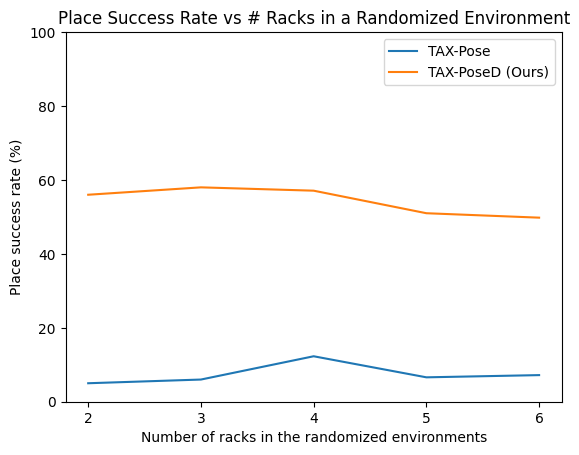

In [7]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

xs = [2, 3, 4, 5, 6]

data = {
    'taxpose': np.array([0.05, 0.06, 0.123, 0.066, 0.072])*100,
    'taxposed': np.array([0.56, 0.58, 0.571, 0.510, 0.498])*100,
}

plt.plot(xs, data['taxpose'], label='TAX-Pose')
plt.plot(xs, data['taxposed'], label='TAX-PoseD (Ours)')
plt.ylim((0, 100))
plt.xlabel("Number of racks in the randomized environments")
plt.ylabel("Place success rate (%)")
plt.xticks(list(range(2, 7)))
plt.title("Place Success Rate vs # Racks in a Randomized Environment")
plt.legend()

plt.show()


In [13]:
# put the mug on the other rack and check p(z|Y)


def vis(base_mug_id, add_smooth=0.05, division_smooth=1, task="mug_1rack_place", markersize=8):
    np.set_printoptions(precision=2)

    

    place_model.eval()
    res = place_model.training_module_no_cond_x.get_transform(points_action_trans, points_anchor_trans, points_action, points_anchor)
    residual_flow_action = res['flow_components']['residual_flow_action']
    goal_emb_action = res['flow_components']['goal_emb'][:, :, :residual_flow_action.shape[1]]
    goal_emb_anchor = res['flow_components']['goal_emb'][:, :, residual_flow_action.shape[1]:]

    res = place_model.get_transform(points_action_trans, points_anchor_trans)
    pred_T_action = res['pred_T_action']
    residual_flow_action = res['flow_components']['residual_flow_action']
    goal_emb_cond_x_action = res['flow_components']['goal_emb_cond_x'][:, :, :residual_flow_action.shape[1]]
    goal_emb_cond_x_anchor = res['flow_components']['goal_emb_cond_x'][:, :, residual_flow_action.shape[1]:]


    #######

    action_pts = toDisplay(points_action)[0]
    anchor_pts = toDisplay(points_anchor)[0]
    action_trans_pts = toDisplay(points_action_trans)[0]
    anchor_trans_pts = toDisplay(points_anchor_trans)[0]

    ######

    layout = go.Layout(
            scene=dict(
                xaxis=dict(
                    showticklabels=False,  # Hide x-axis tick labels
                    title='',              # Remove x-axis title
                    showgrid=False,
                ),
                yaxis=dict(
                    showticklabels=False,  # Hide y-axis tick labels
                    title='',              # Remove y-axis title
                    showgrid=False,
                ),
                zaxis=dict(
                    showticklabels=False,  # Hide z-axis tick labels
                    title='',              # Remove z-axis title
                    showgrid=False,
                ),
            ),
            height=500,
            plot_bgcolor='rgba(0,0,0,0)'
        )

    def plot_with_color(pts, colors, color_scale=False):
        fig2 = go.FigureWidget(layout=layout)

        if not color_scale:
            marker = dict(
                    size=markersize,
                    color=colors,  # Assign the RGB tuples to the 'color' attribute
                )
        else:
            marker = dict(
                    size=markersize,
                    color=colors,  # Assign the RGB tuples to the 'color' attribute
                    colorscale="plasma"
                )
        fig2.add_trace(
            go.Scatter3d(
                x = pts[:,0], 
                y = pts[:,1], 
                z = pts[:,2], 
                mode = 'markers',
                hoverinfo = 'none',
                name='a',
                marker=marker,
            ), 
        )

        return fig2
    
    # min_step=1e-6 is default
    min_step = 1e-6

    # # colors = color_gradient(F.softmax((goal_emb_action[0] + add_smooth)/division_smooth, dim=-1), min_step=min_step)[0]
    # colors = F.softmax((goal_emb_action[0] + add_smooth)/division_smooth, dim=-1)[0].detach().cpu().numpy()
    # fig2 = plot_with_color(action_pts, colors, color_scale=True)
    # fig2.show()

    # # colors = color_gradient(F.softmax((goal_emb_anchor[0] + add_smooth)/division_smooth, dim=-1), min_step=min_step)[0]
    # colors = F.softmax((goal_emb_anchor[0] + add_smooth)/division_smooth, dim=-1)[0].detach().cpu().numpy()
    # fig2 = plot_with_color(anchor_pts, colors, color_scale=True)
    # fig2.show()

    # # colors = color_gradient(F.softmax((goal_emb_cond_x_action[0] + add_smooth)/division_smooth, dim=-1), min_step=min_step)[0]
    # colors = F.softmax((goal_emb_cond_x_action[0] + add_smooth)/division_smooth, dim=-1)[0].detach().cpu().numpy()
    # fig2 = plot_with_color(action_pts, colors, color_scale=True)
    # fig2.show()

    # # colors = color_gradient(F.softmax((goal_emb_cond_x_anchor[0] + add_smooth)/division_smooth, dim=-1), min_step=min_step)[0]
    # colors = F.softmax((goal_emb_cond_x_anchor[0] + add_smooth)/division_smooth, dim=-1)[0].detach().cpu().numpy()
    # fig2 = plot_with_color(anchor_pts, colors, color_scale=True)
    # fig2.show()

    from pytorch3d.transforms import Transform3d, Rotate, Translate, euler_angles_to_matrix

    for i in range(1):
        # T_to_other_rack = random_se3(1, trans_var=0.3, rot_var=np.pi/180 * 180).cuda()
        # print(T_to_other_rack.get_matrix())

        """
        tensor([[[ 0.7886,  0.1625,  0.5931,  0.0000],
         [ 0.4517, -0.8075, -0.3793,  0.0000],
         [ 0.4173,  0.5670, -0.7102,  0.0000],
         [ 0.0425, -0.0201, -0.0217,  1.0000]]], device='cuda:0')
         """
        T_to_other_rack = Rotate(torch.tensor([[0.7886,  0.1625,  0.5931],
                                  [0.4517, -0.8075, -0.3793],
                                  [0.4173,  0.5670, -0.7102]]).T) \
            .translate(0.3, 0.18, 0.08).cuda()
        
        # T_to_other_rack = Rotate(torch.eye(3).T).cuda()
        
        # torch.tensor([[[-0.1779, -0.8197, -0.5445,  0.0000],
        #     [ [-0.1779, -0.8197, -0.5445,  0.0000],
        #     [[-0.1779, -0.8197, -0.5445[-0.1779, -0.8197, -0.5445,  0.0000],
        #     [ 0.0859,  0.2263,  0.0653,  1.0000]]])).cuda()

        # T_to_other_rack = Rotate(euler_angles_to_matrix(torch.tensor([-0.5, -0.5, -0.5]),  convention="ZYZ")).cuda() #.translate(torch.tensor([0, 0, 0.5]))

        post_action_pts = toDisplay(T_to_other_rack.transform_points(points_action_trans))[0]
        colors_action = np.tile((0, 0, 255), (1024, 1))
        colors_anchor = np.tile((255, 0, 0), (1024, 1))
        fig2 = plot_with_color(np.concatenate([post_action_pts, anchor_trans_pts], axis=0), np.concatenate([colors_action, colors_anchor], axis=0))
        fig2.show()

    
    # T_to_other_rack = Rotate(euler_angles_to_matrix(torch.tensor([1, -0.5, -0.5]),  convention="ZYZ")).cuda() #.translate(torch.tensor([0, 0, 0.5]))

    # post_action_pts = toDisplay(T_to_other_rack.transform_points(points_action_trans))[0]
    # colors_action = np.tile((0, 0, 255), (1024, 1))
    # colors_anchor = np.tile((255, 0, 0), (1024, 1))
    # fig2 = plot_with_color(np.concatenate([post_action_pts, anchor_trans_pts], axis=0), np.concatenate([colors_action, colors_anchor], axis=0))
    # fig2.show()

    # T_to_other_rack = Rotate(euler_angles_to_matrix(torch.tensor([0, -0.5, -0.5]),  convention="ZYZ")).cuda() #.translate(torch.tensor([0, 0, 0.5]))

    # post_action_pts = toDisplay(T_to_other_rack.transform_points(points_action_trans))[0]
    # colors_action = np.tile((0, 0, 255), (1024, 1))
    # colors_anchor = np.tile((255, 0, 0), (1024, 1))
    # fig2 = plot_with_color(np.concatenate([post_action_pts, anchor_trans_pts], axis=0), np.concatenate([colors_action, colors_anchor], axis=0))
    # fig2.show()

    # T_to_other_rack = Rotate(euler_angles_to_matrix(torch.tensor([0, -0.5, -0.5]),  convention="ZYZ")).cuda() #.translate(torch.tensor([0, 0, 0.5]))

    # post_action_pts = toDisplay(T_to_other_rack.transform_points(points_action_trans))[0]
    # colors_action = np.tile((0, 0, 255), (1024, 1))
    # colors_anchor = np.tile((255, 0, 0), (1024, 1))
    # fig2 = plot_with_color(np.concatenate([post_action_pts, anchor_trans_pts], axis=0), np.concatenate([colors_action, colors_anchor], axis=0))
    # fig2.show()

vis(1, task=task)

# Base Code

In [96]:
from torch.utils.data import DataLoader

def vis(base_mug_id, add_smooth=0.05, division_smooth=1, task="mug_1rack_place", markersize=8):
    task2configs = {
        "mug_1rack_place": {
            "dataset_root": "/home/jenny/data/taxpose/data/mug_grasp/train_data/renders",
            "test_dataset_root": "/home/jenny/data/taxpose/data/mug_grasp/test_data/renders",
            "action_class": 0,
            "anchor_class": 1,
            "distractor_anchor_aug": False,
            "cloud_type": "teleport",
        },
        "mug_grasp": {
            "dataset_root": "/home/jenny/data/taxpose/data/mug_grasp/train_data/renders",
            "test_dataset_root": "/home/jenny/data/taxpose/data/mug_grasp/test_data/renders",
            "action_class": 2,
            "anchor_class": 0,
            "distractor_anchor_aug": False,
            "cloud_type": "pre_grasp",
        },
        "mug_2rackfixed_place": {
            "dataset_root": "/home/jenny/code/equivariant_pose_graph/data/train_data_duprack_bothmugrack/renders",
            "test_dataset_root": "/home/jenny/code/equivariant_pose_graph/data/test_data_duprack_bothmugrack/renders",
            "action_class": 0,
            "anchor_class": 1,
            "distractor_anchor_aug": False,
            "cloud_type": "teleport",
        },
        "mug_2rackauginf_place": {
            "dataset_root": "/home/jenny/code/equivariant_pose_graph/data/train_data/renders",
            "test_dataset_root": "/home/jenny/code/equivariant_pose_graph/data/test_data/renders",
            "action_class": 0,
            "anchor_class": 1,
            "distractor_anchor_aug": True,
            "cloud_type": "teleport",
        },
        "bottle_place": {
            "dataset_root": "/home/jenny/code/equivariant_pose_graph/data/bottle_place/bottle_train_data_ndf_cons_3/renders",
            "test_dataset_root": "/home/jenny/code/equivariant_pose_graph/data/bottle_place/bottle_train_data_ndf_cons_3/renders",
            # "test_dataset_root": "/home/jenny/code/equivariant_pose_graph/data/bottle_place/bottle_test_new_3/renders",
            
            "action_class": 0,
            "anchor_class": 1,
            "distractor_anchor_aug": False,
            "cloud_type": "teleport",
        },
        "bottle_grasp": {
            "dataset_root": "/home/jenny/code/equivariant_pose_graph/data/bottle_place/bottle_train_data_ndf_cons_3/renders",
            "test_dataset_root": "/home/jenny/code/equivariant_pose_graph/data/bottle_place/bottle_test_new_3/renders",
            "action_class": 2,
            "anchor_class": 0,
            "distractor_anchor_aug": False,
            "cloud_type": "pre_grasp",
        },
         "bowl_place": {
            "dataset_root": "/home/jenny/code/equivariant_pose_graph/data/bowl_place/bowl_train_data_ndf_cons_3/renders/",
            "test_dataset_root": "/home/jenny/code/equivariant_pose_graph/data/bowl_place/bowl_train_data_ndf_cons_3/renders/",
            # "test_dataset_root": "/home/jenny/code/equivariant_pose_graph/data/bowl_place/bowl_test_new_0/renders/",
            "action_class": 0,
            "anchor_class": 1,
            "distractor_anchor_aug": False,
            "cloud_type": "teleport",
        },
        "bowl_grasp": {
            "dataset_root": "/home/jenny/code/equivariant_pose_graph/data/bowl_place/bowl_train_data_ndf_cons_3/renders/",
            "test_dataset_root": "/home/jenny/code/equivariant_pose_graph/data/bowl_place/bowl_test_new_0/renders/",
            "action_class": 2,
            "anchor_class": 0,
            "distractor_anchor_aug": False,
            "cloud_type": "pre_grasp",
        },
    }

    np.set_printoptions(precision=2)
    vis_train = False
    fig2 = go.FigureWidget(
        make_subplots(
                column_widths=[0.3, 0.3, 0.3],
                row_heights=[1, 1],
                rows=2, cols=3,
                specs=[[{'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}], 
                       [{'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}]],
                subplot_titles=([f"Mug #999{base_mug_id}'s p(z)" if not vis_train else f"Mug #999{base_mug_id}'s p(z|Y)",
                                f"Mug #{base_mug_id}'s p(z)" if not vis_train else f"Mug #{base_mug_id}'s p(z|Y)",
                                f"Mug #{base_mug_id}'s p(z|X)",
                                f"Mug #999{base_mug_id}'s p(z)" if not vis_train else f"Mug #999{base_mug_id}'s p(z|Y)",
                                f"Mug #{base_mug_id}'s p(z)" if not vis_train else f"Mug #{base_mug_id}'s p(z|Y)",
                                f"Mug #{base_mug_id}'s p(z|X)"
                                ])
        )
    )
    
    fig2.update_layout(
        height=800,
    )
    
    mug999_dm = MultiviewDataModule(
        dataset_root=task2configs[task]['dataset_root'],
        test_dataset_root=task2configs[task]['test_dataset_root'],
        dataset_index=[f"{base_mug_id}"],
        action_class=task2configs[task]['action_class'],
        anchor_class=task2configs[task]['anchor_class'],
        dataset_size=1000,
        rotation_variance=np.pi/180 * 180,
        translation_variance=0.5,
        batch_size=1,
        num_workers=1,
        cloud_type=task2configs[task]['cloud_type'],
        num_points=1024,
        overfit=True,
        num_overfit_transforms=1,
        seed_overfit_transforms=True,
        set_Y_transform_to_identity=True,
        synthetic_occlusion=False,
        plane_standoff=0.02,
        ball_radius=0.1,
        plane_occlusion=True,
        ball_occlusion=True,
        distractor_anchor_aug=task2configs[task]['distractor_anchor_aug'],
    )
    mug999_dm.setup()
    mug_dm = mug999_dm
    
    sampled_points = {}
    for i, (mug_id, dataloader) in enumerate([
            # [f"999{base_mug_id}", mug999_dm.train_dataloader()], 
            [base_mug_id,         mug_dm.train_dataloader()]
    ]):
        for data in dataloader:
            points_action = data['points_action'].cuda()#[:,:-2]
            points_anchor = data['points_anchor'].cuda()
            
            points_action_trans = data['points_action_trans'].cuda()
            points_anchor_trans = data['points_anchor_trans'].cuda()
            
            points_action_onetrans = data['points_action_onetrans'].cuda()
            points_anchor_onetrans = data['points_anchor_onetrans'].cuda()
            
            T0 = Transform3d(matrix=data['T0'].cuda())
            T1 = Transform3d(matrix=data['T1'].cuda())
            
            break

        if vis_train:
            place_model.train()
            res = place_model.get_transform(points_action_trans, points_anchor_trans,  points_action_onetrans, points_anchor_onetrans)

            pred_T_action = res['pred_T_action']
            residual_flow_action = res['flow_components']['residual_flow_action']
            residual_flow_anchor = res['flow_components']['residual_flow_anchor']
            goal_emb_action = res['flow_components']['goal_emb'][:, :, :residual_flow_action.shape[1]]
            goal_emb_anchor = res['flow_components']['goal_emb'][:, :, residual_flow_action.shape[1]:]
            dense_trans_pt_action = res['flow_components']['dense_trans_pt_action']
            dense_trans_pt_anchor = res['flow_components']['dense_trans_pt_anchor']
            trans_pt_action = res['flow_components']['trans_pt_action']
            trans_pt_anchor = res['flow_components']['trans_pt_anchor']
            trans_sample_action = res['flow_components']['trans_sample_action']
            trans_sample_anchor = res['flow_components']['trans_sample_anchor']
            goal_emb_cond_x_action = res['flow_components']['goal_emb_cond_x'][:, :, :residual_flow_action.shape[1]]
            goal_emb_cond_x_anchor = res['flow_components']['goal_emb_cond_x'][:, :, residual_flow_action.shape[1]:]
        else:
            place_model.eval()
            res = place_model.training_module_no_cond_x.get_transform(points_action_trans, points_anchor_trans, points_action, points_anchor)
            residual_flow_action = res['flow_components']['residual_flow_action']
            residual_flow_anchor = res['flow_components']['residual_flow_anchor']
            goal_emb_action = res['flow_components']['goal_emb'][:, :, :residual_flow_action.shape[1]]
            goal_emb_anchor = res['flow_components']['goal_emb'][:, :, residual_flow_action.shape[1]:]
    
            res = place_model.get_transform(points_action_trans, points_anchor_trans)
            pred_T_action = res['pred_T_action']
            residual_flow_action = res['flow_components']['residual_flow_action']
            residual_flow_anchor = res['flow_components']['residual_flow_anchor']
            dense_trans_pt_action = res['flow_components']['dense_trans_pt_action']
            dense_trans_pt_anchor = res['flow_components']['dense_trans_pt_anchor']
            trans_pt_action = res['flow_components']['trans_pt_action']
            trans_pt_anchor = res['flow_components']['trans_pt_anchor']
            trans_sample_action = res['flow_components']['trans_sample_action']
            trans_sample_anchor = res['flow_components']['trans_sample_anchor']
            goal_emb_cond_x_action = res['flow_components']['goal_emb_cond_x'][:, :, :residual_flow_action.shape[1]]
            goal_emb_cond_x_anchor = res['flow_components']['goal_emb_cond_x'][:, :, residual_flow_action.shape[1]:]


            #######

        post_action_pts = toDisplay(pred_T_action.transform_points(points_action_trans))[0]
        post_anchor_pts = toDisplay(pred_T_action.inverse().transform_points(points_anchor_trans))[0]

        action_pts = toDisplay(points_action)[0]
        anchor_pts = toDisplay(points_anchor)[0]
        action_trans_pts = toDisplay(points_action_trans)[0]
        anchor_trans_pts = toDisplay(points_anchor_trans)[0]

        ######
        
        action_pts_self_dmean = action_pts-action_pts.mean(axis=0)
        anchor_pts_self_dmean = anchor_pts-anchor_pts.mean(axis=0)
        
        action_pts_dmean = action_pts - np.concatenate([action_pts, anchor_pts], axis=0).mean(axis=0)
        goal_emb_action_colors = color_gradient(F.softmax((goal_emb_action[0] + add_smooth)/division_smooth, dim=-1))[0]
        fig2.add_trace(
            go.Scatter3d(
                x = action_pts_dmean[:,0], 
                y = action_pts_dmean[:,1], 
                z = action_pts_dmean[:,2], 
                mode = 'markers',
                hoverinfo = 'none',
                name='a',
                marker=dict(
                    size=markersize,
                    color=goal_emb_action_colors,  # Assign the RGB tuples to the 'color' attribute
                ),
            ), 
            row=1, col=i+1
        )
        sampled_point = action_pts_self_dmean[F.softmax(goal_emb_action[0], dim=-1).argmax()]
        print("Mug p(z|Y) argmax:", sampled_point)
        sampled_points[f"mug_{i}_p_z_cond_y"] = sampled_point
        

        anchor_pts_dmean = anchor_pts - np.concatenate([action_pts, anchor_pts], axis=0).mean(axis=0)
        goal_emb_anchor_colors = color_gradient(F.softmax((goal_emb_anchor[0] + add_smooth)/division_smooth, dim=-1))[0]
        fig2.add_trace(
            go.Scatter3d(
                x = anchor_pts_dmean[:,0], 
                y = anchor_pts_dmean[:,1], 
                z = anchor_pts_dmean[:,2], 
                mode = 'markers',
                hoverinfo = 'none',
                name='a',
                marker=dict(
                    size=markersize,
                    color=goal_emb_anchor_colors,  # Assign the RGB tuples to the 'color' attribute
                ),
            ), 
            row=2, col=i+1
        )
        sampled_point = anchor_pts_self_dmean[F.softmax(goal_emb_anchor[0], dim=-1).argmax()]
        print("Rack p(z|Y) argmax:", sampled_point)
        sampled_points[f"rack_{i}_p_z_cond_y"] = sampled_point


    action_trans_pts_dmean = action_trans_pts - action_trans_pts.mean(axis=0)
    goal_emb_cond_x_action_colors = color_gradient(F.softmax((goal_emb_cond_x_action[0] + add_smooth)/division_smooth, dim=-1)[0])
    fig2.add_trace(
        go.Scatter3d(
            x = action_pts[:,0], 
            y = action_pts[:,1], 
            z = action_pts[:,2], 
            mode = 'markers',
            hoverinfo = 'none',
            name='a',
            marker=dict(
                size=markersize,
                color=goal_emb_cond_x_action_colors,  # Assign the RGB tuples to the 'color' attribute
            ),
        ), 
        row=1, col=3
    )
    print('action goal emb cond x mean: ', goal_emb_cond_x_action[0].mean())
    goal_emb_cond_x_action_colors = color_gradient(F.softmax((goal_emb_cond_x_action[0] + add_smooth)/division_smooth, dim=-1)[0])
    # fig2.data[4].marker.color = goal_emb_cond_x_action_colors
    sampled_point = action_pts_self_dmean[F.softmax(goal_emb_cond_x_action[0], dim=-1).argmax()]
    print("Mug p(z|X) argmax:", sampled_point)
    sampled_points[f"mug_p_z_cond_x"] = sampled_point
    

    anchor_trans_pts_dmean = anchor_trans_pts - anchor_trans_pts.mean(axis=0)
    goal_emb_cond_x_anchor_colors = color_gradient(F.softmax((goal_emb_cond_x_anchor[0] + add_smooth)/division_smooth, dim=-1))[0]
    fig2.add_trace(
        go.Scatter3d(
            x = anchor_pts_dmean[:,0], 
            y = anchor_pts_dmean[:,1], 
            z = anchor_pts_dmean[:,2], 
            mode = 'markers',
            hoverinfo = 'none',
            name='a',
            marker=dict(
                size=markersize,
                color=goal_emb_cond_x_anchor_colors,  # Assign the RGB tuples to the 'color' attribute
            ),
        ), 
        row=2, col=3
    )
    print('anchor goal emb cond x mean:', goal_emb_cond_x_anchor[0].mean())
    
    # goal_emb_cond_x_anchor_colors = color_gradient(F.softmax((goal_emb_cond_x_anchor[0] + add_smooth)/division_smooth, dim=-1))[0]
    # print('colors', goal_emb_cond_x_anchor_colors)
    # fig2.data[5].marker.color = goal_emb_cond_x_anchor_colors
    sampled_point = anchor_pts_self_dmean[F.softmax(goal_emb_cond_x_anchor[0], dim=-1).argmax()]
    print("Rack p(z|X) argmax:", sampled_point)
    sampled_points[f"rack_p_z_cond_x"] = sampled_point
    
    
    error_R_max0, error_R_min0, error_R_mean0 = get_degree_angle(T0.inverse().compose(
                        T1).compose(pred_T_action.inverse()))
    error_t_max0, error_t_min0, error_t_mean0 = get_translation(T0.inverse().compose(
                T1).compose(pred_T_action.inverse()))
    error_R_max1, error_R_min1, error_R_mean1 = get_degree_angle(T0.inverse().translate(0.3, 0, 0).compose(
                T1).compose(pred_T_action.inverse()))
    error_R_max2, error_R_min2, error_R_mean2 = get_degree_angle(T0.inverse().translate(-0.3, 0, 0).compose(
                T1).compose(pred_T_action.inverse()))
    error_t_max1, error_t_min1, error_t_mean1 = get_translation(T0.inverse().translate(0.3, 0, 0).compose(
                T1.compose(pred_T_action.inverse())))
    error_t_max2, error_t_min2, error_t_mean2 = get_translation(T0.inverse().translate(-0.3, 0, 0).compose(
                            T1.compose(pred_T_action.inverse())))
    error_R_mean = min(error_R_mean0, error_R_mean1, error_R_mean2)
    error_t_mean = min(error_t_mean0, error_t_mean1, error_t_mean2)
    
    print(f'Mug#{mug_id} {"Train error" if vis_train else "Val error"} R: {error_R_mean}, t: {error_t_mean}')
    
    
    print(f'Mug point range: ' + \
              f'({action_pts_self_dmean[:,0].min():.2f}, {action_pts_self_dmean[:,0].max():.2f}) ' + \
              f'({action_pts_self_dmean[:,1].min():.2f}, {action_pts_self_dmean[:,1].max():.2f}) ' + \
              f'({action_pts_self_dmean[:,2].min():.2f}, {action_pts_self_dmean[:,2].max():.2f})')
    print(f'Rack point range: ' + \
              f'({anchor_pts_self_dmean[:,0].min():.2f}, {anchor_pts_self_dmean[:,0].max():.2f}) ' + \
              f'({anchor_pts_self_dmean[:,1].min():.2f}, {anchor_pts_self_dmean[:,1].max():.2f}) ' + \
              f'({anchor_pts_self_dmean[:,2].min():.2f}, {anchor_pts_self_dmean[:,2].max():.2f})')
    
#     only_mug = False
#     if only_mug:
#         def test(goal_emb_cond_x, goal_emb):
#             B, K, D = goal_emb.shape
#             goal_emb_loss = F.kl_div(F.log_softmax(goal_emb_cond_x[:, :, :], dim=-1), F.log_softmax(goal_emb[:, :, :], dim=-1), log_target=True, reduction='batchmean')
#             return goal_emb_loss

#         print(f"Mug KL: {test(goal_emb_cond_x_action, goal_emb_action).item():.3f}")
#     else:
#         def test(goal_emb_cond_x, goal_emb):
#             B, K, D = goal_emb.shape
#             goal_emb_loss = F.kl_div(F.log_softmax(goal_emb_cond_x[:, :, :], dim=-1), F.log_softmax(goal_emb[:, :, :], dim=-1), log_target=True, reduction='batchmean') \
#             return goal_emb_loss


#     print(f"Rack KL: {test(goal_emb_cond_x_anchor, goal_emb_anchor).item():.3f}, Mug KL: {test(goal_emb_cond_x_action, goal_emb_action).item():.3f}")

    
    def calc_error(actual, target):
        return np.linalg.norm(actual - target)
    
    if calc_error(sampled_points[f"mug_p_z_cond_x"], sampled_points[f"mug_0_p_z_cond_y"]) > calc_error(sampled_points[f"mug_p_z_cond_x"], sampled_points[f"mug_1_p_z_cond_y"]):
        print(f"Mug L2 err {calc_error(sampled_points[f'mug_p_z_cond_x'], sampled_points[f'mug_1_p_z_cond_y'])}")
    else:
        print(f"Mug L2 err {calc_error(sampled_points[f'mug_p_z_cond_x'], sampled_points[f'mug_0_p_z_cond_y'])}")
        
        
    if calc_error(sampled_points[f"rack_p_z_cond_x"], sampled_points[f"rack_0_p_z_cond_y"]) > calc_error(sampled_points[f"rack_p_z_cond_x"], sampled_points[f"rack_1_p_z_cond_y"]):
        print(f"Rack L2 err {calc_error(sampled_points[f'rack_p_z_cond_x'], sampled_points[f'rack_1_p_z_cond_y'])}")
    else:
        print(f"Rack L2 err {calc_error(sampled_points[f'rack_p_z_cond_x'], sampled_points[f'rack_0_p_z_cond_y'])}")
        

    layout = go.Layout(
        scene=dict(
            xaxis=dict(
                showticklabels=False,  # Hide x-axis tick labels
                title='',              # Remove x-axis title
            ),
            yaxis=dict(
                showticklabels=False,  # Hide y-axis tick labels
                title='',              # Remove y-axis title
            ),
            zaxis=dict(
                showticklabels=False,  # Hide z-axis tick labels
                title='',              # Remove z-axis title
            ),
        )
    )

    # Add the layout to your existing figure
    fig2.update_layout(layout)

    return fig2



In [97]:
#### 0, 1, 2, 3, 4, 6, 8, 10, 11, 14, 22, 28
vis(10, task=task)

TRAIN Dataset
/home/jenny/code/equivariant_pose_graph/data/bottle_place/bottle_train_data_ndf_cons_3/renders
/home/jenny/code/equivariant_pose_graph/data/bottle_place/bottle_train_data_ndf_cons_3/renders/10_teleport_obj_points.npz

Overfitting transform lists in PointCloudDataset:
	-TO: [tensor([[[-0.3465, -0.0628, -0.9359,  0.0000],
         [ 0.4024,  0.8913, -0.2088,  0.0000],
         [ 0.8474, -0.4490, -0.2836,  0.0000],
         [-0.2084, -0.2688,  0.0775,  1.0000]]])]
	-T1: [tensor([[[-0.3138,  0.5444,  0.7779,  0.0000],
         [-0.9006, -0.4301, -0.0624,  0.0000],
         [ 0.3006, -0.7202,  0.6253,  0.0000],
         [ 0.1793, -0.0461,  0.0241,  1.0000]]])]
	-T2: [tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]])]
VAL Dataset
/home/jenny/code/equivariant_pose_graph/data/bottle_place/bottle_train_data_ndf_cons_3/renders/10_teleport_obj_points.npz

Overfitting transform lists in PointCloudDataset:
	-TO: [tensor([[[-0

FigureWidget({
    'data': [{'hoverinfo': 'none',
              'marker': {'color': array([[  0.,   0., 255.],
                                         [  0.,   0., 255.],
                                         [  0.,   0., 255.],
                                         ...,
                                         [  0.,   0., 255.],
                                         [  0.,   0., 255.],
                                         [  0.,   0., 255.]]),
                         'size': 8},
              'mode': 'markers',
              'name': 'a',
              'scene': 'scene',
              'type': 'scatter3d',
              'uid': '49177c8b-aad4-42fc-a3cb-241386075854',
              'x': array([-0.06,  0.03,  0.01, ..., -0.01, -0.02, -0.04], dtype=float32),
              'y': array([-0.03,  0.06,  0.03, ..., -0.01, -0.01,  0.07], dtype=float32),
              'z': array([ 0.07, -0.02,  0.18, ...,  0.17,  0.14,  0.08], dtype=float32)},
             {'hoverinfo': 'none',
     

In [10]:
#### 0, 1, 2, 3, 4, 6, 8, 10, 11, 14, 22, 28

vis(1)

TRAIN Dataset
/home/jenny/data/taxpose/data/mug_grasp/train_data/renders
/home/jenny/data/taxpose/data/mug_grasp/train_data/renders/1_pre_grasp_obj_points.npz

Overfitting transform lists in PointCloudDataset:
	-TO: [tensor([[[ 0.4226,  0.7497, -0.5093,  0.0000],
         [-0.8577,  0.1492, -0.4920,  0.0000],
         [-0.2929,  0.6448,  0.7060,  0.0000],
         [ 0.0535,  0.0609,  0.0234,  1.0000]]])]
	-T1: [tensor([[[ 5.4887e-01, -1.2942e-01,  8.2583e-01,  0.0000e+00],
         [-4.9779e-01,  7.4305e-01,  4.4729e-01,  0.0000e+00],
         [-6.7152e-01, -6.5660e-01,  3.4342e-01,  0.0000e+00],
         [ 1.2892e-02,  1.2668e-02, -5.3782e-04,  1.0000e+00]]])]
	-T2: [tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]])]
VAL Dataset
/home/jenny/data/taxpose/data/mug_grasp/test_data/renders/1_pre_grasp_obj_points.npz

Overfitting transform lists in PointCloudDataset:
	-TO: [tensor([[[ 0.4226,  0.7497, -0.5093,  0.0000],
         [

FigureWidget({
    'data': [{'hoverinfo': 'none',
              'marker': {'color': array([[  0.,   0., 255.],
                                         [  0.,   0., 255.],
                                         [  0.,   0., 255.],
                                         ...,
                                         [  0.,   0., 255.],
                                         [  0.,   0., 255.],
                                         [  0.,   0., 255.]])},
              'mode': 'markers',
              'name': 'a',
              'scene': 'scene',
              'type': 'scatter3d',
              'uid': '5b36ebee-355a-4ee2-9299-4245bf88973c',
              'x': array([ 0.05,  0.05, -0.05, ..., -0.05,  0.08, -0.04], dtype=float32),
              'y': array([-0.01, -0.09,  0.04, ...,  0.  , -0.09, -0.  ], dtype=float32),
              'z': array([ 0.14, -0.02,  0.02, ...,  0.1 ,  0.09,  0.13], dtype=float32)},
             {'hoverinfo': 'none',
              'marker': {'color': array([

In [11]:
#### 0, 1, 2, 3, 4, 6, 8, 10, 11, 14, 22, 28

vis(2)

TRAIN Dataset
/home/jenny/data/taxpose/data/mug_grasp/train_data/renders
/home/jenny/data/taxpose/data/mug_grasp/train_data/renders/2_pre_grasp_obj_points.npz

Overfitting transform lists in PointCloudDataset:
	-TO: [tensor([[[ 0.4226,  0.7497, -0.5093,  0.0000],
         [-0.8577,  0.1492, -0.4920,  0.0000],
         [-0.2929,  0.6448,  0.7060,  0.0000],
         [ 0.0535,  0.0609,  0.0234,  1.0000]]])]
	-T1: [tensor([[[ 5.4887e-01, -1.2942e-01,  8.2583e-01,  0.0000e+00],
         [-4.9779e-01,  7.4305e-01,  4.4729e-01,  0.0000e+00],
         [-6.7152e-01, -6.5660e-01,  3.4342e-01,  0.0000e+00],
         [ 1.2892e-02,  1.2668e-02, -5.3782e-04,  1.0000e+00]]])]
	-T2: [tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]])]
VAL Dataset
/home/jenny/data/taxpose/data/mug_grasp/test_data/renders/2_pre_grasp_obj_points.npz

Overfitting transform lists in PointCloudDataset:
	-TO: [tensor([[[ 0.4226,  0.7497, -0.5093,  0.0000],
         [

FigureWidget({
    'data': [{'hoverinfo': 'none',
              'marker': {'color': array([[  0.,   0., 255.],
                                         [  0.,   0., 255.],
                                         [  0.,   0., 255.],
                                         ...,
                                         [  0.,   0., 255.],
                                         [  0.,   0., 255.],
                                         [  0.,   0., 255.]])},
              'mode': 'markers',
              'name': 'a',
              'scene': 'scene',
              'type': 'scatter3d',
              'uid': 'a123d1f4-3c9f-4ed8-8bf5-77923e499a9b',
              'x': array([ 0.  , -0.09,  0.06, ..., -0.04, -0.09,  0.01], dtype=float32),
              'y': array([ 0.02,  0.02, -0.02, ..., -0.04, -0.01, -0.  ], dtype=float32),
              'z': array([ 0.14, -0.02,  0.02, ...,  0.11,  0.06, -0.02], dtype=float32)},
             {'hoverinfo': 'none',
              'marker': {'color': array([

In [11]:
#### 0, 1, 2, 3, 4, 6, 8, 10, 11, 14, 22, 28

vis(3)

Mug p(z|Y) argmax: [ 0.05  0.01 -0.04]
Rack p(z|Y) argmax: [ 0.2  -0.04 -0.15]
Mug p(z|Y) argmax: [-0.01 -0.09  0.03]
Rack p(z|Y) argmax: [-0.14  0.03  0.19]
action goal emb cond x mean:  tensor(-0.0430, device='cuda:0', grad_fn=<MeanBackward0>)
Mug p(z|X) argmax: [-0.01 -0.09  0.03]
anchor goal emb cond x mean: tensor(0.0433, device='cuda:0', grad_fn=<MeanBackward0>)
Rack p(z|X) argmax: [ 0.2  -0.04 -0.15]
Mug#3 Train error R: 1.299954891204834, t: 0.04034368321299553
Mug point range: (-0.08, 0.14) (-0.09, 0.10) (-0.10, 0.10)
Rack point range: (-0.20, 0.20) (-0.12, 0.06) (-0.15, 0.19)
Rack KL: 1.243, Mug KL: 0.275
Mug L2 err 0.0
Rack L2 err 8.940696716308594e-08


FigureWidget({
    'data': [{'hoverinfo': 'none',
              'marker': {'color': array([[  0.  , 148.56, 21…

In [11]:
#### 0, 1, 2, 3, 4, 6, 8, 10, 11, 14, 22, 28

vis(4)

Global seed set to 0


/home/jwang/code/equivariant_pose_graph/data/train_data_duprack_bothmugrack/renders/9994_teleport_obj_points.npz


Global seed set to 0


Mug p(z|Y) argmax: [-0.03  0.    0.06]
Rack p(z|Y) argmax: [-0.16 -0.07  0.05]
/home/jwang/code/equivariant_pose_graph/data/train_data_duprack_bothmugrack/renders/4_teleport_obj_points.npz
Mug p(z|Y) argmax: [-0.08  0.04  0.04]
Rack p(z|Y) argmax: [-0.14 -0.07  0.06]
Mug p(z|X) argmax: [ 0.03 -0.09 -0.02]
Rack p(z|X) argmax: [ 0.2  -0.05 -0.15]
Mug point range: (-0.08, 0.13) (-0.10, 0.11) (-0.11, 0.10)
Rack point range: (-0.20, 0.20) (-0.12, 0.06) (-0.15, 0.20)
Mug L2 err 0.13933579623699188
Rack L2 err 0.40025103092193604


FigureWidget({
    'data': [{'hoverinfo': 'none',
              'marker': {'color': array([[  0.  ,  25.11, 24…

In [17]:
#### 0, 1, 2, 3, 4, 6, 8, 10, 11, 14, 22, 28

vis(6)

Global seed set to 0


/home/jwang/code/equivariant_pose_graph/data/train_data_duprack_bothmugrack/renders/9996_teleport_obj_points.npz


Global seed set to 0


Mug p(z|Y) argmax: [ 0.   -0.08 -0.07]
Rack p(z|Y) argmax: [-0.2   0.06 -0.15]
/home/jwang/code/equivariant_pose_graph/data/train_data_duprack_bothmugrack/renders/6_teleport_obj_points.npz
Mug p(z|Y) argmax: [ 0.   -0.08 -0.07]
Rack p(z|Y) argmax: [ 0.1   0.06 -0.15]
Mug p(z|X) argmax: [-0.01 -0.08 -0.07]
Rack p(z|X) argmax: [-0.2   0.06 -0.15]
Mug point range: (-0.07, 0.12) (-0.11, 0.11) (-0.12, 0.11)
Rack point range: (-0.20, 0.21) (-0.12, 0.06) (-0.15, 0.20)
Mug L2 err 0.011166311800479889
Rack L2 err 7.450580596923828e-08


FigureWidget({
    'data': [{'hoverinfo': 'none',
              'marker': {'color': array([[  0.  , 112.59, 22…

In [18]:
#### 0, 1, 2, 3, 4, 6, 8, 10, 11, 14, 22, 28

vis(8)

Global seed set to 0


/home/jwang/code/equivariant_pose_graph/data/train_data_duprack_bothmugrack/renders/9998_teleport_obj_points.npz


Global seed set to 0


Mug p(z|Y) argmax: [ 0.02 -0.06 -0.06]
Rack p(z|Y) argmax: [-0.2   0.06 -0.15]
/home/jwang/code/equivariant_pose_graph/data/train_data_duprack_bothmugrack/renders/8_teleport_obj_points.npz
Mug p(z|Y) argmax: [ 0.03 -0.05 -0.08]
Rack p(z|Y) argmax: [ 0.1   0.06 -0.15]
Mug p(z|X) argmax: [ 0.03  0.02 -0.06]
Rack p(z|X) argmax: [-0.2   0.06 -0.15]
Mug point range: (-0.08, 0.13) (-0.10, 0.12) (-0.11, 0.10)
Rack point range: (-0.20, 0.20) (-0.12, 0.06) (-0.15, 0.20)
Mug L2 err 0.0753258764743805
Rack L2 err 2.9802322387695312e-08


FigureWidget({
    'data': [{'hoverinfo': 'none',
              'marker': {'color': array([[  0.  , 134.79, 21…

In [19]:
#### 0, 1, 2, 3, 4, 6, 8, 10, 11, 14, 22, 28

vis(10)

Global seed set to 0


/home/jwang/code/equivariant_pose_graph/data/train_data_duprack_bothmugrack/renders/99910_teleport_obj_points.npz


Global seed set to 0


Mug p(z|Y) argmax: [-0.01  0.05 -0.06]
Rack p(z|Y) argmax: [-0.2   0.06 -0.15]
/home/jwang/code/equivariant_pose_graph/data/train_data_duprack_bothmugrack/renders/10_teleport_obj_points.npz
Mug p(z|Y) argmax: [ 0.03  0.02 -0.08]
Rack p(z|Y) argmax: [ 0.1   0.06 -0.15]
Mug p(z|X) argmax: [-0.    0.05 -0.06]
Rack p(z|X) argmax: [-0.2   0.06 -0.15]
Mug point range: (-0.08, 0.13) (-0.10, 0.11) (-0.11, 0.11)
Rack point range: (-0.20, 0.21) (-0.12, 0.06) (-0.15, 0.20)
Mug L2 err 0.01063369307667017
Rack L2 err 0.0


FigureWidget({
    'data': [{'hoverinfo': 'none',
              'marker': {'color': array([[  0.  ,  44.26, 24…

In [133]:
#### 0, 1, 2, 3, 4, 6, 8, 10, 11, 14, 22, 28

vis(11)

Global seed set to 0


/home/jwang/code/equivariant_pose_graph/data/train_data_duprack_bothmugrack/renders/99911_teleport_obj_points.npz


Global seed set to 0


Mug p(z|Y) argmax: [-0.01  0.06 -0.05]
Rack p(z|Y) argmax: [-0.2   0.06 -0.15]
/home/jwang/code/equivariant_pose_graph/data/train_data_duprack_bothmugrack/renders/11_teleport_obj_points.npz
Mug p(z|Y) argmax: [ 0.01 -0.04 -0.06]
Rack p(z|Y) argmax: [ 0.1   0.06 -0.15]
Mug p(z|X) argmax: [ 0.01 -0.04 -0.06]
Rack p(z|X) argmax: [-0.2   0.06 -0.15]
Mug point range: (-0.08, 0.13) (-0.10, 0.11) (-0.10, 0.10)
Rack point range: (-0.20, 0.20) (-0.12, 0.06) (-0.15, 0.20)
Mug L2 err 0.0
Rack L2 err 7.450580596923828e-08


FigureWidget({
    'data': [{'hoverinfo': 'none',
              'marker': {'color': array([[  0.  , 134.79, 21…

In [134]:
#### 0, 1, 2, 3, 4, 6, 8, 10, 11, 14, 22, 28

vis(14)

Global seed set to 0


/home/jwang/code/equivariant_pose_graph/data/train_data_duprack_bothmugrack/renders/99914_teleport_obj_points.npz


Global seed set to 0


Mug p(z|Y) argmax: [-0.01  0.05 -0.06]
Rack p(z|Y) argmax: [-0.2   0.05 -0.15]
/home/jwang/code/equivariant_pose_graph/data/train_data_duprack_bothmugrack/renders/14_teleport_obj_points.npz
Mug p(z|Y) argmax: [-0.    0.03 -0.07]
Rack p(z|Y) argmax: [ 0.1   0.06 -0.15]
Mug p(z|X) argmax: [-0.    0.03 -0.07]
Rack p(z|X) argmax: [ 0.1   0.06 -0.15]
Mug point range: (-0.08, 0.13) (-0.09, 0.10) (-0.10, 0.10)
Rack point range: (-0.20, 0.20) (-0.12, 0.06) (-0.15, 0.20)
Mug L2 err 0.0
Rack L2 err 0.0


FigureWidget({
    'data': [{'hoverinfo': 'none',
              'marker': {'color': array([[  0.  , 184.87, 19…

In [135]:
#### 0, 1, 2, 3, 4, 6, 8, 10, 11, 14, 22, 28

vis(22)

Global seed set to 0


/home/jwang/code/equivariant_pose_graph/data/train_data_duprack_bothmugrack/renders/99922_teleport_obj_points.npz


Global seed set to 0


Mug p(z|Y) argmax: [-0.03  0.06 -0.04]
Rack p(z|Y) argmax: [-0.2   0.06 -0.15]
/home/jwang/code/equivariant_pose_graph/data/train_data_duprack_bothmugrack/renders/22_teleport_obj_points.npz
Mug p(z|Y) argmax: [ 0.   -0.06 -0.04]
Rack p(z|Y) argmax: [ 0.1   0.06 -0.15]
Mug p(z|X) argmax: [-0.   -0.05 -0.05]
Rack p(z|X) argmax: [-0.2   0.06 -0.15]
Mug point range: (-0.08, 0.13) (-0.10, 0.11) (-0.11, 0.11)
Rack point range: (-0.20, 0.20) (-0.12, 0.06) (-0.15, 0.20)
Mug L2 err 0.015196074731647968
Rack L2 err 4.470348358154297e-08


FigureWidget({
    'data': [{'hoverinfo': 'none',
              'marker': {'color': array([[  0.  ,  10.2 , 25…

In [136]:
#### 0, 1, 2, 3, 4, 6, 8, 10, 11, 14, 22, 28

vis(28)

Global seed set to 0


/home/jwang/code/equivariant_pose_graph/data/train_data_duprack_bothmugrack/renders/99928_teleport_obj_points.npz


Global seed set to 0


Mug p(z|Y) argmax: [ 0.01 -0.06 -0.06]
Rack p(z|Y) argmax: [-0.2   0.06 -0.15]
/home/jwang/code/equivariant_pose_graph/data/train_data_duprack_bothmugrack/renders/28_teleport_obj_points.npz
Mug p(z|Y) argmax: [ 0.02 -0.05 -0.07]
Rack p(z|Y) argmax: [ 0.1   0.06 -0.15]
Mug p(z|X) argmax: [-0.01 -0.06 -0.07]
Rack p(z|X) argmax: [-0.2   0.06 -0.15]
Mug point range: (-0.08, 0.12) (-0.11, 0.11) (-0.11, 0.10)
Rack point range: (-0.20, 0.20) (-0.12, 0.06) (-0.15, 0.20)
Mug L2 err 0.012674111872911453
Rack L2 err 5.960464477539063e-08


FigureWidget({
    'data': [{'hoverinfo': 'none',
              'marker': {'color': array([[  0.  ,  71.44, 23…